In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf.scf import hf

import matplotlib as mpl
mpl.style.use("seaborn")
ticker = mpl.ticker

from SCFInitialGuess.utilities.analysis import density_cut, matrix_error

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset

molecules = np.load("../data/molecules.npy")
S = np.load("../data/S.npy")
P = np.load("../data/P.npy")

dataset, molecules_split =  make_butadien_dataset(molecules, S, P)


[-] 2018-05-28 13:43:39: Data set normalized. Mean value std: 0.008732722987069362


In [3]:
index = 166
dim = 26


#mole = molecules[index].get_pyscf_molecule()
s = S[index].reshape(dim, dim)
p = P[index].reshape(dim, dim)

In [4]:
z_value = 3
nx = 80
ny = 80

norm = None#plt.Normalize(0, 7.6e-5)

In [5]:
from pyscf.gto import Mole

mole = Mole()
mole.atom = """
   C        4.33091        1.98230        0.00000
   C        3.21425        1.24567        0.00000
   H        4.30836        3.06736        0.00000
   H        5.30544        1.50418        0.00000
   C        1.89367        1.82420        0.00000
   C        0.77642        1.08809        0.00000
   H        0.79858        0.00302        0.00000
   H       -0.19786        1.56668        0.00000
   H        3.29578        0.16068        0.00000
   H        1.81231        2.90922        0.00000
"""
mole.basis = "6-311++g**"
mole.build()

Warn: Ipython shell catchs sys.args


In [6]:
coords = mole.atom_coords()[:, 2]
np.mean(coords), np.std(coords)

(0.0, 0.0)

# H_core

In [7]:
dm_1e = hf.init_guess_by_1e(mole)
dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z_value)

In [8]:
np.max(dm_1e_density), np.min(dm_1e_density)


(88.58807642915394, 9.792400297880988e-08)

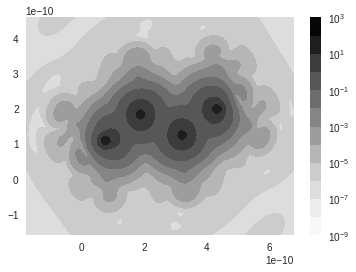

In [9]:
plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

In [10]:
"""
for z in np.linspace(-1,5, 20):    
    dm_1e = hf.init_guess_by_1e(mole)
    dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z)
    plt.figure()
    plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator())
    plt.colorbar()
    plt.title("z = " + str(z))
plt.show()
"""

'\nfor z in np.linspace(-1,5, 20):    \n    dm_1e = hf.init_guess_by_1e(mole)\n    dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z)\n    plt.figure()\n    plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator())\n    plt.colorbar()\n    plt.title("z = " + str(z))\nplt.show()\n'

# SAP

In [11]:
dm_sap = hf.init_guess_by_atom(mole)
dm_sap_density, x, y = density_cut(mole, dm_sap, nx, ny, z_value)

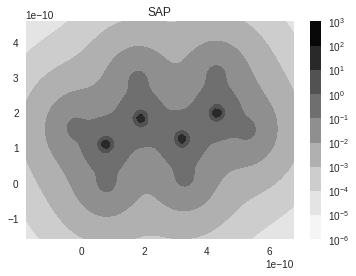

In [12]:
plt.contourf(*np.meshgrid(x, y), dm_sap_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("SAP")
plt.show()

# GWH

In [13]:
dm_gwh = hf.init_guess_by_wolfsberg_helmholtz(mole)
dm_gwh_density, x, y = density_cut(mole, dm_gwh, nx, ny, z_value)

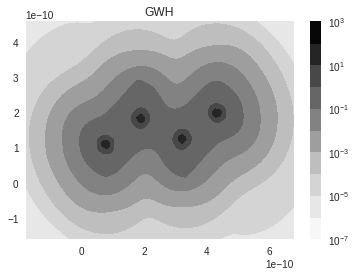

In [14]:
plt.contourf(*np.meshgrid(x, y), dm_gwh_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("GWH")
plt.show()

# MINAO

In [15]:
dm_minao = hf.init_guess_by_minao(mole)
dm_minao_density, x, y = density_cut(mole, dm_minao, nx, ny, z_value)

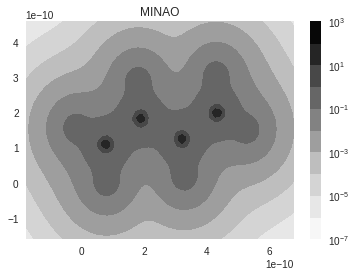

In [16]:
plt.contourf(*np.meshgrid(x, y), dm_minao_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("MINAO")
plt.show()

# NN

In [17]:
import tensorflow as tf
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../data/network.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

In [18]:
mole_sto = mole
mole_sto.basis = "sto-3g"
mole_sto.build()


s_test = hf.get_ovlp(mole_sto)

s_test_norm = dataset.input_transformation(s.reshape(-1, dim**2))

Warn: Ipython shell catchs sys.args


In [19]:

dm_nn = network.run(sess, s_test_norm).reshape(dim, dim).astype("float64")
dm_nn_density, x, y = density_cut(mole, dm_nn, nx, ny, z_value) 

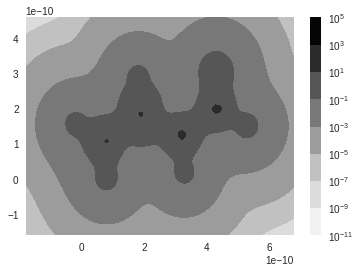

In [20]:
plt.contourf(*np.meshgrid(x, y), dm_nn_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# Subplot

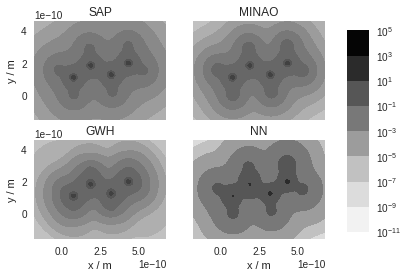

In [21]:
fig, axes = plt.subplots(2, 2)

vmin = 1e-11
vmax = 1e5

ylabel = "y / m"
xlabel = "x / m"

norm = plt.Normalize(vmin, vmax)

axes[0,0].contourf(*np.meshgrid(x, y), dm_sap_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,0].set_title("SAP")
axes[0,0].ticklabel_format(style='plain', axis='x')
axes[0,0].set_ylabel(ylabel)



axes[1,0].contourf(*np.meshgrid(x, y), dm_gwh_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[1,0].set_title("GWH")
axes[1,0].set_xlabel(xlabel)
axes[1,0].set_ylabel(ylabel)

axes[0,1].contourf(*np.meshgrid(x, y), dm_minao_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,1].set_title("MINAO")
axes[0,1].ticklabel_format(style='plain')


im = axes[1,1].contourf(*np.meshgrid(x, y), dm_nn_density, locator=ticker.LogLocator(),  vmin=vmin, vmax=vmax)
axes[1,1].set_title("NN")
axes[1,1].ticklabel_format(style='plain', axis='y')
axes[1,1].set_xlabel(xlabel)

_ = plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
_ = plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("/home/jcartus/Repos/cc2aiPoster/densities/density_cuts.pdf")
#

In [25]:
mf = hf.RHF(mole)
mf.verbose=4
mf.run()



******** <class 'pyscf.scf.hf.RHF'> flags ********
method = RHF
initial guess = minao
damping factor = 0
level shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
DIIS start cycle = 1
DIIS space = 8
SCF tol = 1e-09
SCF gradient tol = None
max. SCF cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/jcartus/Repos/SCFInitialGuess/butadien/notebooks/tmpzxmwrj6p
max_memory 4000 MB (current use 335 MB)
Set gradient conv threshold to 3.16228e-05
init E= -154.087269393636
  HOMO = -0.191890781955228  LUMO = 0.0732077375054195
cycle= 1 E= -152.993526060367  delta_E= 1.09  |g|= 0.224  |ddm|= 3.71
  HOMO = -0.24326898458459  LUMO = 0.249214247702603
cycle= 2 E= -153.015030481502  delta_E= -0.0215  |g|= 0.0531  |ddm|= 0.413
  HOMO = -0.264222654403277  LUMO = 0.237429420790202
cycle= 3 E= -153.016499322003  delta_E= -0.00147  |g|= 0.00693  |ddm|= 0.121
  HOMO = -0.260689792547207  LUMO = 0.242529853867803
cycle= 4 E= -153.016525976993  delta_E= -2.67e-05  